In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm.notebook import trange
from IPython.display import clear_output

# Sampling from probability distributions

$X$ --- random variable, p($X$) --- probability distribution.
The goal is to sample $X$ from probability distribution p($X$)

## Bernoulli sampling

$X\in \{ 0,1 \}$ , p --- probability$(X=1)$.
The goal is to sample zeros and ones from the discrete probability distribution {1-p,p}


### Recipe

- Create a tensor (probs_uniform) of uniformly distributed (torch.rand) between zero and one random numbers 
- if probs_uniform$[i]$ $<$  p, then X = 1, otherwise X = 0

In [2]:
# Write your code here
prob = 0.7
N_samples = 100 
outcomes = torch.rand(N_samples)<prob
outcomes.sum()

tensor(68)

- Calculate variance of Bernoulli distribution analytically and compare it with numerical estimations

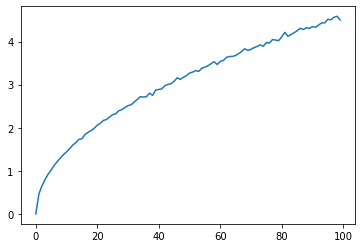

In [3]:
# Write your code here 
N_times = 10000
std = []
for i in range(100):
    rnd = torch.rand(N_times,i)
    outcomes = (rnd<prob).sum(1)
    std.append(outcomes.type(torch.float32).std())
plt.plot(std)    




## Sampling from multinomial distribution 

Now, we know how to flip a coin on a laptop (aka Bernoulli sampling). 
Next goal is to sample events from a discrete distribution of any dimension. 

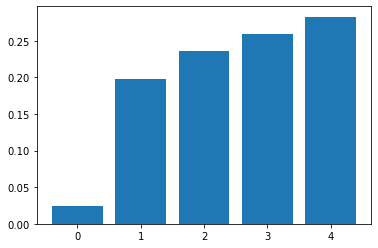

In [4]:
# Here the distribution is generated
dim = 5
probs = torch.rand(dim)
probs = torch.sort(probs)[0]
probs /= probs.sum()

plt.bar(np.arange(dim),probs)
plt.show()

## Multinomial sampling

- $X\in \{ 0,1, ... , dim-1 \}$ , probs --- [probability$(X=0)$,probability$(X=1)$, ... , probability$(X=dim-1)$].
- The goal is to sample  $\{ 0,1, ... , dim-1 \}$ from the discrete probability distribution defined by tensor "probs"

### Hint
- Use the same logic as in the Bernoulli sampling
- Instead of one coin, use multiple coins, each coin corresponds to its own probability in "probs"

In [5]:
# Write your code here
N_samples = 
probs_sampled = 

SyntaxError: invalid syntax (<ipython-input-5-2625d53ae1e1>, line 2)

NameError: name 'probs_sampled' is not defined

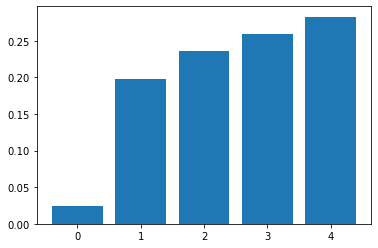

In [6]:
plt.bar(np.arange(dim),probs,label='Ideal')
plt.bar(np.arange(dim),probs_sampled,label='Sampled',alpha = 0.5)
plt.legend()
plt.show()

# Metropolis algorithm 
## What if the dimension of the probability space is exponentially big, but, you still want to sample the most probable outcomes?

## Toy model
- There are $2^{dim}$ probabilities  
- Neural network (NN) is a black box, which encodes probability distribution in its parameters
- The input layer of NN is a bit string, the output is the corresponding log of unnormalized probability 

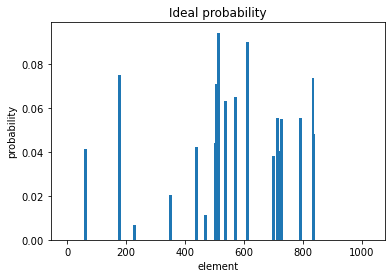

In [7]:
# Here the probability distribution (probs_theory) is generated
# dim is the number of bits
dim = 10
# N is the number of nonzero probabilities among 2^dim
N = 20
probs_nonzero = torch.rand(N)
probs_nonzero /= probs_nonzero.sum()
inds = torch.randint(0,2**dim,(N,))
probs_theory = torch.zeros(2**dim)
probs_theory[inds] = probs_nonzero
plt.bar(torch.arange(2**dim),probs_theory,width = 10)
plt.title('Ideal probability')
plt.xlabel('element')
plt.ylabel('probability')
plt.show()

- Class Net defines neural network
- The input layer is bit string, the output is a corresponding log probability

In [8]:
class Net(nn.Module):
    
    lr = 0.001
    N_epochs = 500
     
    def __init__(self,dim,probs_theory): 
        super(Net,self).__init__()
        self.dim = dim
        self.probs_theory = probs_theory
        nhid = 300
        
        self.linear0 = nn.Linear(dim,nhid)
        self.linear1 = nn.Linear(nhid,nhid)
        self.linear2 = nn.Linear(nhid,1)

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        
        self.bn = nn.BatchNorm1d(nhid)
        
    def int10tobase_torch(self,num,base=2):
        c = num
        max_digit = self.dim-1
        res = torch.zeros((max_digit+1,num.shape[0]),dtype = torch.long)
        i = max_digit
        while(torch.sum(c)!=0):
            res[i,:] = torch.remainder(c,base)
            c = (c/base).type(torch.long)
            i-=1
        return res.t()
        
    def forward(self,x):
        x = self.linear0(x)
        x = self.relu(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x
    
    def prob_dist(self,x_in):
        logprobs = self(x_in)[:,0]
        logZ = torch.logsumexp(logprobs,dim=0)
        return logprobs,logZ
    
    def negloglik(self,inds,eps=1e-8):
        x_in = self.int10tobase_torch(inds).type(torch.float32)
        logprobs,logZ = self.prob_dist(x_in)
        return -(probs_theory[inds]*logprobs).sum() + logZ
    
    def evolution(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, betas=(0.9, 0.999))
        loss_ar = []
        count = 0
        inds = torch.arange(2**dim)
        for e in range(self.N_epochs):
            optimizer.zero_grad()
            loss_cur = self.negloglik(inds)
            loss_cur.backward()
            optimizer.step()
            count += 1
            loss_ar.append(loss_cur.detach().numpy())
            if (count==10):
                clear_output(True)
                plt.plot(loss_ar)
                plt.show()
                count = 0
        return loss_ar

Your goal is to train neural network

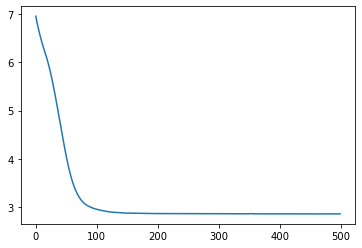

In [9]:
# Write your code here
net = Net(dim,probs_theory)
loss_ar = net.evolution()

In [10]:
# Make bar plots of ideal and network probabilities 
# Write your code here
outcomes_all = net.int10tobase_torch(torch.arange(2 ** dim)).type(torch.float32)
logprobs,logZ = net.prob_dist(outcomes_all)

In [11]:
probs_np = torch.exp(logprobs - logZ).detach()

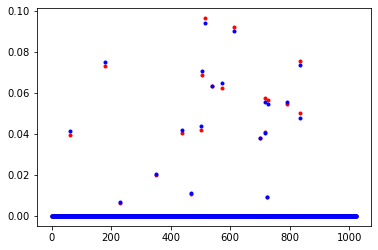

In [12]:
plt.plot(probs_np, ".", color = 'red')
plt.plot(probs_theory, ".", color = 'blue')

# Metropolis algorithm (for discrete distributions)

## Recipe
1. Create an initial batch (set) of bit strings, $\{x_{old}\}$
2. Generate new batch from old one by flipping random bit in each configuration, $\{x_{new}\}$ 
3. Calculate log probabilities  $\log p_{new}$ and $\log p_{old}$ using trained NN
4. Calculate set of ratios $r = \frac{p_{new}}{p_{old}}$
4. If $r>1$, then accept $x_{new}$
5. If $r<1$, play Bernoully game to accept $x_{new}$ or keep $x_{old}$
6. Repeat actions from 2 to 5

In [31]:
N_samples = 200
Nsteps = 30
dims = torch.arange(N_samples)
# Write your code here
outcomes_old = torch.randint(0,2,(N_samples,dim)).type(torch.float32)
for _ in trange(Nsteps):
    inds_flip = torch.randint(0,dim,(N_samples,))
    outcomes_new = torch.clone(outcomes_old)
    outcomes_new[torch.arange(N_samples),inds_flip] = 1 - outcomes_old[torch.arange(N_samples),inds_flip]

    logprob_old, logZ_old = net.prob_dist(outcomes_old)
    logprob_new, logZ_new = net.prob_dist(outcomes_new)
    r = torch.exp(logprob_new - logprob_old)

    inds_accept = torch.nonzero((torch.rand(N_samples) < r))[:,0]
    outcomes_old[inds_accept,:] = outcomes_new[inds_accept,:]

- Choose unique bit string among sampled via Metropolis
- Compare them with the ideal set
- Calculate probabilities for this unique set of bit strings

In [32]:
# Write your code here
dims = torch.arange(dim-1,-1,-1,dtype=torch.float32)
outcomes_unique = torch.unique(outcomes_old, dim=0).type(torch.float32)
logprobs, logZ = net.prob_dist(outcomes_unique)
probs_net = torch.exp(logprobs - logZ).detach().numpy()
inds_unique = outcomes_unique.type(torch.float32)@(2**dims)
print('sampled unique outcomes ',inds_unique.type(torch.long))
print('ideal outcomes',inds.sort()[0])

sampled unique outcomes  tensor([ 62, 178, 228, 230, 350, 438, 452, 468, 473, 476, 500, 502, 505, 510,
        514, 515, 538, 572, 574, 611, 699, 715, 718, 723, 727, 739, 792, 798,
        834, 835, 862, 966, 982])
ideal outcomes tensor([ 62, 178, 228, 350, 438, 468, 502, 505, 514, 538, 572, 611, 699, 715,
        718, 723, 727, 792, 834, 835])


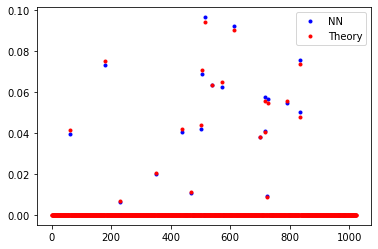

In [33]:
plt.plot(inds_unique,probs_net,'.',color = 'blue',label = 'NN')
plt.plot(probs_theory, ".", color = 'red',label='Theory')
plt.legend()
plt.show()